# Aeration Example Code

In [0]:
!pip install aguaclara

In [0]:
from aguaclara.core.units import unit_registry as u
import aguaclara as ac
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections


In [0]:
def aeration_data(DO_column, dirpath):
    """This function extracts the data from a folder containing tab delimited
    files of aeration data. The files must be the original tab delimited file.
    The names of the files must be listed in a text file called metadata.txt.

    Parameters
    ----------
    DO_column : int
        index of the column that contains the dissolved oxygen concentration
        data.
    dirpath : string
        path to the directory containing aeration data you want to analyze
    Returns
    -------
    filepaths : string list
        all file paths in the directory sorted by flow rate
    airflows : air flow rates in micromol/s (from the metafile)
    time_data : numpy array list
        sorted list of numpy arrays containing the times with units of seconds
    DO_data : dissolved oxygen concentrations (mg/L)    
    Examples
    --------
    """
    #return the list of files in the directory
    metadata = pd.read_csv(dirpath + '/metadata.txt', delimiter='\t')
    filenames = metadata['file name']
    #print(filenames)
    airflows = np.array(metadata['flow (micromol/s)']) * u.umol/u.s
    #print(airflows.magnitude)
    #extract the flowrates from the filenames and apply units
    #sort airflows and filenames so that they are in ascending order of flow rates
    filepaths = [dirpath + '/' + i for i in filenames]
    #C_data is a list of numpy arrays. Thus each of the numpy data arrays can have different lengths to accommodate short and long experiments
    # cycle through all of the files and extract the column of data with oxygen concentrations and the times
    time_data=[(ac.column_of_time(i,1,-1)).to(u.s) for i in filepaths]
    #print(time_data)
    DO_data=[ac.column_of_data(i,1,DO_column,-1,'mg/L') for i in filepaths]
    aeration_collection = collections.namedtuple('aeration_results','metadata filenames airflows DO_data time_data')
    aeration_results = aeration_collection(metadata, filenames, airflows, DO_data, time_data)
    return aeration_results
    #return time_data


DO_column = 2
dirpath = "https://raw.githubusercontent.com/monroews/CEE4530/master/Examples/data/Aeration_2020"
metadata, filenames, airflows, DO_data, time_data = aeration_data(DO_column,dirpath)


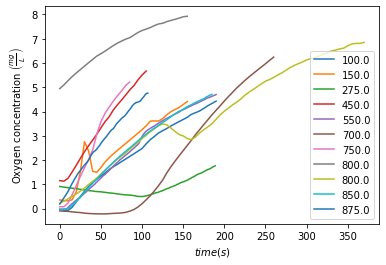

In [13]:
# Plot the raw data
for i in range(airflows.size):
  plt.plot(time_data[i], DO_data[i],'-');
plt.xlabel(r'$time (s)$');
plt.ylabel(r'Oxygen concentration $\left ( \frac{mg}{L} \right )$');
plt.legend(airflows.magnitude);
plt.show()

#delete data that is less than 2 or greater than 6 mg/L
DO_min = 2 * u.mg/u.L
DO_max = 6 * u.mg/u.L
for i in range(airflows.size):
  idx_start = (np.abs(DO_data[i]-DO_min)).argmin()
  idx_end = (np.abs(DO_data[i]-DO_max)).argmin()
  time_data[i] = time_data[i][idx_start:idx_end] - time_data[i][idx_start]
  DO_data[i] = DO_data[i][idx_start:idx_end]
